# Disorder regions prediction - Host-Virus domain-motif interactions

In [39]:
import pandas as pd
import requests as r
from Bio import SeqIO
import re
import os
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

##### A function for creating a directory even if it already exists

In [40]:
def makdir(folder_name):
    try:
        os.makedirs(folder_name)
    except FileExistsError:
        pass

##### 1 - A function for analysis of information between two different dataset : elm instances and elm classes by tsv format

In [41]:
def make_dictionary_match_uniprot_regex(elm_instances, elm_classes, species):
    
    with open(elm_instances) as elm_instances:
        with open(elm_classes) as elm_classes:
            dict_uniprot_regex = dict()
            elm_instances = [line.split('\n')[0].strip().split('\t') for line in elm_instances]
            elm_classes = [line.split('\n')[0].strip().split('\t') for line in elm_classes]
            
            # The first line in each file is the headers
            for instance in elm_instances[1:]:
                for classes in elm_classes[1:]:
                    
                    #The place of elmidentifier in instance and classes data
                    elmidentifier_instance, elmidentifier_classes = instance[2], classes[1]
                    
                    #Replacing quotation marks in the data to None'
                    regex, organism, primary_acc = classes[4].replace('"', ''), instance[-1].replace('"', ''), instance[4].replace('"', '')
                    
                    #If there is a match between the elmidentifier with the specific organism create a dictionary where the key is the unique uniprot id and the value is all the matching Regex'
                    if elmidentifier_classes == elmidentifier_instance and re.search(species, organism):
                        if primary_acc in dict_uniprot_regex:
                            dict_uniprot_regex[primary_acc].append(regex)
                        else:
                            dict_uniprot_regex[primary_acc] = [regex]
                            
            return dict_uniprot_regex

##### 2 - A function for download the species protein sequences of the unique uniprot id from uniprot server

In [42]:
def download_uniport_seq(dict_uniprot_regex, fasta_seq_protein_uniprot, folder_sequence_uniprot):
    
    with open(fasta_seq_protein_uniprot, 'w') as output_union_fasta_seq:
        
        #Create a fasta file of all species sequences by uniport ID
        uniport_id = dict_uniprot_regex.keys()
        makdir(folder_sequence_uniprot)
        for identity in uniport_id:
            
            #Create a file of each sequence by uniport ID
            with open(folder_sequence_uniprot + identity + '.fasta', 'w') as output_seq:
                
                # Url address of uniprot website
                url_path_uniprot = "http://www.uniprot.org/uniprot/"
                
                # Match to the unique uniprot id sequence for download
                current_url = url_path_uniprot + identity + ".fasta"
                response = r.post(current_url)
                
                # Receiving the information output from uniprot
                fasta_uniprot_seq_data = ''.join(response.text)
                
                # Write the each sequences into the directory and into the union sequences file
                output_union_fasta_seq.writelines(fasta_uniprot_seq_data)
                output_seq.writelines(fasta_uniprot_seq_data)


##### 3 - A function for run Iupred software for the purpose of predicting regions of protein that are in disorder area

In [43]:
def apply_iupred_software(folder_sequence_uniprot, folder_result_iupred):
    
    makdir(folder_result_iupred)
    list_name_uniprot_seq = os.listdir(folder_sequence_uniprot)

    # For each sequence run the command in Iupred software by the script iupred2a and write the result into a directory make sure that python3 app will appear in App execution aliases;
    # long = long disorder; software parameter
    
    for name in list_name_uniprot_seq:
        cmd_iupred = 'python3 iupred2a.py ' + folder_sequence_uniprot + name + ' long > ' + folder_result_iupred + name.split('.')[0] + '.txt'
        os.system(cmd_iupred)
        
#cmd_iupred = 'python3 iupred2a.py {} {} long > {} {}.txt'.format(folder_sequence_uniprot,name,folder_result_iupred, name.split('.')[0])


##### 4 - A function for search the motif in the protein sequnce by the Regex and integration to the result of the Iupred prediction for each motif 

In [44]:
def disorder_value_motif_start_end(fasta_seq_protein_uniprot, dict_uniprot_regex, folder_result_iupred, species):
    
    with open(fasta_seq_protein_uniprot) as elm_instances_fasta_seq:
        list_id = []
        list_seq = []
        
        # Open the fasta file of all sequences by uniport ID and make a dictionary were the key is the uniprot id and the value is the protein sequnce
        for record in SeqIO.parse(elm_instances_fasta_seq, 'fasta'):
            identifier, sequence = record.id, record.seq
            list_id.append(identifier)
            list_seq.append(sequence)
        dict_fatsa_uniprot_seq = dict(zip(list_id, list_seq))
        results_disorder_value_iupred = []
        for uniprot_id in dict_uniprot_regex:
            
            #Regex_pattern is the regular expression pattern the value of the dictionary
            regex_pattern = dict_uniprot_regex[uniprot_id]
            for key_identifier in dict_fatsa_uniprot_seq:
                
                #Key_identifier in place [1] is the name of the uniport id on the dictionary
                seq_uniprot_id = str(dict_fatsa_uniprot_seq[key_identifier])
                
                #Seq_uniprot_id is the sequnce of the protein of each unique uniprot id'
                if uniprot_id == key_identifier.split('|')[1]:
                    for regex in regex_pattern:
                        
                        #If there is match between uniport ID to key_identifier search the motif in the sequnce
                        search_motif = re.search(regex, seq_uniprot_id)
                        if search_motif is not None:
                            
                            #Find the start end of the motif of each sequnce
                            start_regex = re.search(regex, seq_uniprot_id).start()
                            end_regex = re.search(regex, seq_uniprot_id).end()
                            
                            #Open the file of the Iupred result of the unique uniport ID
                            with open(folder_result_iupred + uniprot_id + '.txt') as result_iupred:
                                result_iupred = [line.split('\n')[0].strip() for line in result_iupred if
                                                 not line.startswith('#')]
                                #Found the position residue and Iupred rate of each amino acid
                                for line in result_iupred:
                                    
                                    pos, res, iupred_rate = line.split()[0], line.split()[1], float(line.split()[2])
                                    
                                    #Found only the residue that in the range of the start end of the motif
                                    #the sequnce start from 1 and not from 0 like the regex pattern
                                    
                                    if int(pos) in range(start_regex + 1, end_regex + 1):
                                        result = res, iupred_rate, species
                                        results_disorder_value_iupred.append(result)    
                                    else:
                                        pass
                                    
        return results_disorder_value_iupred

##### 5 - A Function for creating figures based on the results of the analysis 

In [45]:
def make_figures(virus_data, human_data):
    
    df_virus = pd.DataFrame(virus_data, columns=['res', 'Iupred_disorder_value', 'organism'])
    
    # Groupby by the mean base on the Virus data frame by the residue column
    df_virus_scatter = df_virus.groupby(['res'], as_index=False).mean()
    
    # Human data frame
    df_human = pd.DataFrame(human_data, columns=['res', 'Iupred_disorder_value', 'organism'])
    
    # Groupby by the mean base on the Human dataframe by the residue column
    df_human_scatter = df_human.groupby(['res'], as_index=False).mean()
    
    # Merge Human and virus to one dataframe by the residue column
    df_merge_col_human_virus = pd.merge(df_human_scatter, df_virus_scatter, on='res', suffixes=('_Human', '_Virus'))
    sns.axes_style("darkgrid")
    f, ax = plt.subplots(figsize=(8, 8))
    
    # Limit x,y axis
    ax.set(ylim=(0.2, 0.75))
    ax.set(xlim=(0.2, 0.75))
    ax.set_title('Human vs Virus disorder value paired by amino acid')
    sns.despine(f, left=True, bottom=True)
    
    # Scatter plot figure
    sns.scatterplot(x="Iupred_disorder_value_Human", y="Iupred_disorder_value_Virus", hue="res",
                    sizes=(1, 1), linewidth=0, data=df_merge_col_human_virus, ax=ax, palette="icefire")
    
    # Y=X line add to the plot for better Visualization
    xpoints = ypoints = ax.get_xlim()
    ax.plot(xpoints, ypoints, linestyle='--', color='k', lw=0.5, scalex=False, scaley=False)
    
    # Regression line plot figure
    sns.regplot(x="Iupred_disorder_value_Human", y="Iupred_disorder_value_Virus", scatter=False,data=df_merge_col_human_virus,color='gray')
    ax.set(xlabel='Iupred disorder value Human', ylabel='Iupred disorder value Virus')
    plt.legend(loc='lower right')
    plt.show()

    # Calculate Person correlation coefficient and 2 tailed p value for the scatter plot
    colums_human = df_merge_col_human_virus['Iupred_disorder_value_Human']
    colums_virus = df_merge_col_human_virus['Iupred_disorder_value_Virus']
    pearson = scipy.stats.pearsonr(colums_human, colums_virus)
    pearsons_correlation_coefficient, tow_tailed_p_value = pearson[0], pearson[1]
    print('Pearsons_correlation_coefficient:', pearsons_correlation_coefficient)
    print('Pearsons 2_tailed_p-value:', pearson[1])

    # Preparation for producing Boxplot and Histograma figures by concat the human dataframe and the virus dataframe to one union dataframe'
    union = [df_human, df_virus]
    df_union = pd.concat(union, ignore_index=True)

    # Box plot figure
    plt.figure(figsize=[10, 6])
    ax = sns.boxplot(x="organism", y="Iupred_disorder_value", data=df_union, showfliers=False, palette="cubehelix")
    ax.set_title('Human vs Virus average Iupred disorder value')
    ax.set(xlabel='Organism', ylabel='Iupred disorder value')

    #Calculate number of obs per group & median to position labels
    medians = df_union.groupby(["organism"])['Iupred_disorder_value'].median().values
    nobs = df_union['organism'].value_counts().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n = " + i for i in nobs]
    'Add it to the plot'
    pos = range(len(nobs))
    for tick, label in zip(pos, ax.get_xticklabels()):
        ax.text(pos[tick], medians[tick], nobs[tick], horizontalalignment='center', size='small',
                color='black', weight='semibold')
    sns.despine(offset=10, trim=True)
    plt.show()

    # Histograma figure
    plt.figure(figsize=[10, 6])
    ax = sns.histplot(data=df_union, x='Iupred_disorder_value', hue='organism', kde=True, bins=30, palette="cubehelix")
    ax.set_title('Human vs Virus distribution disorder motif')
    ax.set(xlabel='Iupred disorder value')
    sns.despine(offset=10, trim=True)
    plt.show()

    #Calculate mannwhitneyu p-value two-sided for the two distributions
    u_value, p_value_two_sided = scipy.stats.mannwhitneyu(colums_human, colums_virus, use_continuity=True,alternative='two-sided')
    print('mannwhitneyu p-value two-sided: ', p_value_two_sided)

### Steps for executing the code #
 

##### First stage 

In [46]:
# Virus
Virus_dictionary_uniprot_regex = make_dictionary_match_uniprot_regex(elm_instances='elm_instances.tsv',
                                                               elm_classes='elm_classes.tsv', species='virus')
# Human
Human_dictionary_uniprot_regex = make_dictionary_match_uniprot_regex(elm_instances='elm_instances.tsv',
                                                               elm_classes='elm_classes.tsv', species='Homo sapiens')




##### Second stage

In [47]:
# Virus
download_uniport_seq(dict_uniprot_regex = Virus_dictionary_uniprot_regex,
                     fasta_seq_protein_uniprot = 'Fasta_seq_protein_uniprot_virus.txt',
                     folder_sequence_uniprot ='sequence_uniprot_virus\\')

# Human
download_uniport_seq(dict_uniprot_regex= Human_dictionary_uniprot_regex,
                     fasta_seq_protein_uniprot='Fasta_seq_protein_uniprot_human.txt',
                     folder_sequence_uniprot='sequence_uniprot_human\\')



##### Third stage 

In [48]:
# Virus
apply_iupred_software(folder_sequence_uniprot='sequence_uniprot_virus\\', folder_result_iupred='result_iupred_virus\\')

# Human
apply_iupred_software(folder_sequence_uniprot='sequence_uniprot_human\\', folder_result_iupred='result_iupred_human\\')


##### Fourth stage

In [49]:
# Virus
Virus_disorder_value_iupred = disorder_value_motif_start_end(fasta_seq_protein_uniprot ='Fasta_seq_protein_uniprot_virus.txt',
                                                       dict_uniprot_regex = Virus_dictionary_uniprot_regex,
                                                       folder_result_iupred ='result_iupred_virus\\',
                                                       species='Virus')

# Human
Human_disorder_value_iupred = disorder_value_motif_start_end(fasta_seq_protein_uniprot ='Fasta_seq_protein_uniprot_human.txt',
                                                       dict_uniprot_regex = Human_dictionary_uniprot_regex,
                                                       folder_result_iupred ='result_iupred_human\\',
                                                       species='Homo sapiens')

##### Five stage

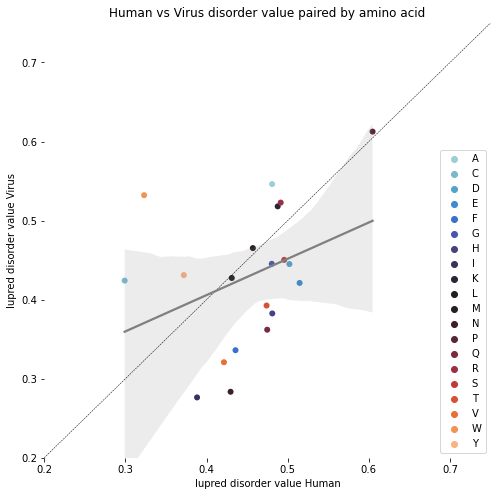

Pearsons_correlation_coefficient: 0.3569329508353237
Pearsons 2_tailed_p-value: 0.1223770368270573


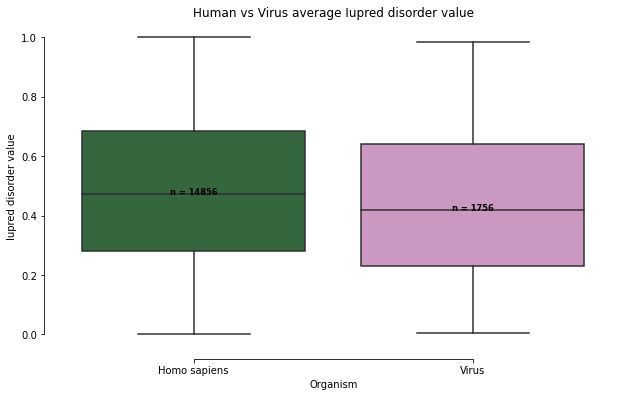

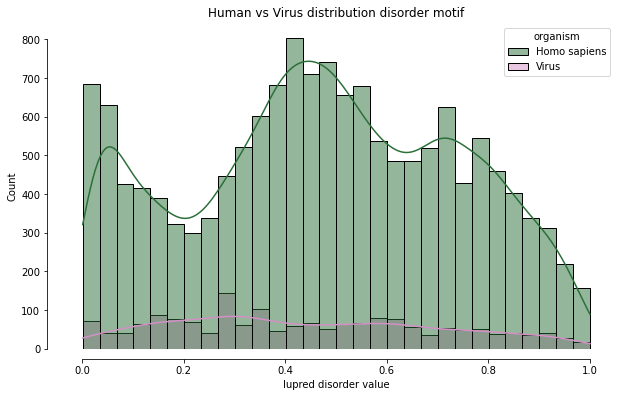

mannwhitneyu p-value two-sided:  0.29767675447218034


In [50]:
make_figures(Virus_disorder_value_iupred, Human_disorder_value_iupred)